# Combined Dataset

## PREPROCESSING

In [6]:
df_1 = pd.read_csv("/Users/riasanjay/Desktop/Mental-Health-Application/Data_with_updated_paths.csv")

In [7]:
df_1.head()

path       label modification
0  /Users/riasanjay/Desktop/Mental-Health-Applica...  male_angry        noisy
1  /Users/riasanjay/Desktop/Mental-Health-Applica...  male_angry    stretched
2  /Users/riasanjay/Desktop/Mental-Health-Applica...  male_angry      shifted
3  /Users/riasanjay/Desktop/Mental-Health-Applica...  male_angry        noisy
4  /Users/riasanjay/Desktop/Mental-Health-Applica...  male_angry    stretched

In [8]:
df_1.label.count()

6300

In [9]:
df_1.label.value_counts()

label
male_angry         450
male_disgust       450
male_fear          450
male_happy         450
male_neutral       450
male_sad           450
male_surprise      450
female_neutral     450
female_sad         450
female_happy       450
female_angry       450
female_surprise    450
female_disgust     450
female_fear        450
Name: count, dtype: int64

## CNN

## Building the model

In [25]:
# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras import layers, models

def create_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')  # For single-label classification
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Example usage
cnn_model = create_cnn(input_shape=(128, 128, 1), num_classes=14)  # e.g., 128x128 Mel spectrograms


In [27]:
file_path

'/Users/riasanjay/Desktop/Mental-Health-Application/output_2/shifted_3087.wav'

## Training the model

## LSTM

In [30]:
import librosa
import numpy as np

# Updated feature extraction function with padding or truncation
def extract_features(file_path, n_mfcc=40, max_len=200):
    """
    Extract MFCC features from an audio file and ensure a fixed shape.
    Args:
        file_path (str): Path to the audio file.
        n_mfcc (int): Number of MFCC features to extract.
        max_len (int): Fixed length for padding or truncation.
    Returns:
        np.array: MFCC features of shape (max_len, n_mfcc).
    """
    try:
        # Load audio file
        y, sr = librosa.load(file_path, sr=16000)
        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        # Pad or truncate to fixed length
        if mfccs.shape[1] < max_len:
            mfccs = np.pad(mfccs, ((0, 0), (0, max_len - mfccs.shape[1])), mode='constant')
        else:
            mfccs = mfccs[:, :max_len]
        return mfccs.T  # Transpose to shape (time_steps, n_mfcc)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Apply feature extraction
X = []
y = []
modifications = []

for _, row in df_1.iterrows():
    file_path = row['path']
    label = row['label']
    modification = row['modification']

    # Extract features
    features = extract_features(file_path)
    if features is not None:  # Skip files that failed to process
        X.append(features)
        y.append(label)
        modifications.append(modification)

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)
modifications = np.array(modifications)

print(f"Feature array shape: {X.shape}")  # Should print (num_samples, max_len, n_mfcc)
print(f"Labels array shape: {y.shape}")   # Should print (num_samples,)
print(f"Modifications array shape: {modifications.shape}")

Feature array shape: (6300, 200, 40)
Labels array shape: (6300,)
Modifications array shape: (6300,)


In [31]:
from tensorflow.keras.utils import to_categorical

# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Check label mapping
print(encoder.classes_)

['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y_categorical, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

NameError: name 'X' is not defined

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.3),
    
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(y_train.shape[1], activation='softmax')  # Output layer for multi-class classification
])

In [34]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    verbose=1
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 200, 128)          86528     
                                                                 
 dropout_4 (Dropout)         (None, 200, 128)          0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 14)               

In [35]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

# Print the test results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
# Predict on a batch of test data (e.g., the first 5 test samples)
predictions = model.predict(X_test[:5])

# Print the predictions and the corresponding true labels
print(f"Predictions: {predictions}")
print(f"True Labels: {y_test[:5]}")

30/30 [==============================] - 2s 73ms/step - loss: 1.7715 - accuracy: 0.3503
Test Loss: 1.7715
Test Accuracy: 0.3503
1/1 [==============================] - 1s 809ms/step
Predictions: [[2.85282294e-04 3.75729433e-05 1.44743724e-04 9.43933555e-05
  2.99288640e-05 8.92925600e-05 3.00710562e-05 3.81397679e-02
  1.33494407e-01 1.81722101e-02 1.75646544e-02 4.16714877e-01
  3.61383259e-01 1.38196191e-02]
 [2.04035803e-03 1.57463562e-03 6.60033766e-05 1.68132377e-04
  4.91629005e-04 5.14508574e-04 1.17417854e-04 9.63962004e-02
  8.76833871e-02 2.12320194e-01 2.36032397e-01 9.01385210e-03
  6.94687441e-02 2.84112632e-01]
 [4.43480647e-04 2.29362282e-04 8.59029387e-05 1.08628730e-04
  1.09077861e-04 1.62157216e-04 5.32719059e-05 8.75213519e-02
  2.77180046e-01 9.36436877e-02 9.29637700e-02 1.29257664e-01
  2.38086998e-01 8.01545903e-02]
 [2.72067235e-04 8.46940384e-05 1.62760174e-04 9.17859288e-05
  6.10613206e-05 1.46335660e-04 4.12196969e-05 3.90158854e-02
  1.38321221e-01 2.471041

## Model with accuracy 79

In [ ]:
# lets pick up the meta-data that we got from our first part of the Kernel
ref = pd.read_csv("/Users/riasanjay/Desktop/Mental-Health-Application/Data_path.csv")
ref.head()

labels source                                               path
0  male_angry  SAVEE  /Users/riasanjay/Desktop/Mental-Health-Applica...
1  male_angry  SAVEE  /Users/riasanjay/Desktop/Mental-Health-Applica...
2  male_angry  SAVEE  /Users/riasanjay/Desktop/Mental-Health-Applica...
3  male_angry  SAVEE  /Users/riasanjay/Desktop/Mental-Health-Applica...
4  male_angry  SAVEE  /Users/riasanjay/Desktop/Mental-Health-Applica...

In [ ]:
# Importing required libraries 
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
from tqdm import tqdm
import pickle
import IPython.display as ipd  # To play sound in the notebook

In [14]:
#########################
# Augmentation methods
#########################
def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.05*np.random.uniform()*np.amax(data)   # more noise reduce the value to 0.5
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*1000)  #default at 500
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound. Note that this expands the dataset slightly
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=-0.5 ,high=7)  # default low = 1.5, high = 3
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

####################################
# the confusion matrix heat map plot
####################################
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Note this takes a couple of minutes (~16 mins) as we're iterating over 4 datasets, and with augmentation  
df = pd.DataFrame(columns=['feature'])
df_noise = pd.DataFrame(columns=['feature'])
df_speedpitch = pd.DataFrame(columns=['feature'])
cnt = 0

# loop feature extraction over the entire dataset
for i in tqdm(ref.path):
    
    # first load the audio 
    X, sample_rate = librosa.load(i
                                  , res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100
                                  ,offset=0.5
                                 )
    
    '''X, sample_rate = librosa.load(i, res_type='kaiser_fast', duration=2.5, sr=None, offset=0.5)'''

    # take mfcc and mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=np.array(sample_rate), 
                                        n_mfcc=13),
                    axis=0)
    
    df.loc[cnt] = [mfccs]   

    # random shifting (omit for now)
    # Stretch
    # pitch (omit for now)
    # dyn change
    
    # noise 
    aug = noise(X)
    aug = np.mean(librosa.feature.mfcc(y=aug, 
                                    sr=np.array(sample_rate), 
                                    n_mfcc=13),    
                  axis=0)
    df_noise.loc[cnt] = [aug]

    # speed pitch
    aug = speedNpitch(X)
    aug = np.mean(librosa.feature.mfcc(y=aug, 
                                    sr=np.array(sample_rate), 
                                    n_mfcc=13),    
                  axis=0)
    df_speedpitch.loc[cnt] = [aug]   

    cnt += 1

df.head()

In [19]:
# combine 
df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
df_noise = pd.concat([ref,pd.DataFrame(df_noise['feature'].values.tolist())],axis=1)
df_speedpitch = pd.concat([ref,pd.DataFrame(df_speedpitch['feature'].values.tolist())],axis=1)
print(df.shape,df_noise.shape,df_speedpitch.shape)

(10771, 238) (10771, 238) (10771, 238)


In [ ]:
df = pd.concat([df,df_noise,df_speedpitch],axis=0,sort=False)
df=df.fillna(0)
del df_noise, df_speedpitch

df.head()

labels source                                               path  \
0  male_angry  SAVEE  /Users/riasanjay/Desktop/Mental-Health-Applica...   
1  male_angry  SAVEE  /Users/riasanjay/Desktop/Mental-Health-Applica...   
2  male_angry  SAVEE  /Users/riasanjay/Desktop/Mental-Health-Applica...   
3  male_angry  SAVEE  /Users/riasanjay/Desktop/Mental-Health-Applica...   
4  male_angry  SAVEE  /Users/riasanjay/Desktop/Mental-Health-Applica...   

          0          1          2          3          4          5          6  \
0 -2.268425  -4.317077 -12.285237 -13.083024 -12.041327 -11.819769  -9.414148   
1 -8.690718 -12.522837 -22.928043 -23.243807 -22.926605 -23.432241 -14.830002   
2 -4.641419  -3.860897  -6.219191  -5.926542  -5.850420  -4.808960  -2.513001   
3 -8.814859 -12.819055 -24.178183 -23.847450 -15.182785 -10.732484  -8.681471   
4  0.795040  -2.392278 -13.791661 -11.645016 -10.858607 -11.128168 -10.862834   

   ...  225  226  227  228  229  230  231  232  233  234  
0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 238 columns]

In [21]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

0          1          2          3          4          5    \
1713  -57.486111 -53.702328 -56.503250 -59.790791 -53.486881 -47.397774   
9384  -14.666087 -13.480311 -13.870711 -14.827724 -14.746232 -15.190939   
7709  -21.198790 -18.385921 -18.336088 -18.867878 -17.950544 -15.741281   
708   -59.434700 -59.434700 -59.434700 -59.434700 -59.434700 -59.434700   
6920  -20.375776 -16.585245 -17.051918 -17.515929 -18.582889 -17.783329   
5686  -24.112934 -20.455650 -20.393320 -20.137907 -18.436663 -19.316435   
10373  -7.142340  -7.271200  -9.214400 -10.089161  -9.444166  -9.302917   
1256  -58.194641 -58.194641 -57.278172 -55.509026 -55.067448 -56.387932   
9740  -18.882305 -17.126631 -15.214510 -14.840484 -16.247923 -17.220823   
4708  -20.310453 -15.699579 -14.587940 -13.457937 -10.324624 -11.460540   

             6          7          8          9    ...        225        226  \
1713  -49.752174 -53.130802 -53.274006 -53.443829  ... -30.796347 -31.786140   
9384  -15.475887 -16.914639 -17.293314 -16.670729  ...   0.000000   0.000000   
7709  -16.947649 -17.108948 -15.871996 -16.344398  ...   0.000000   0.000000   
708   -59.434700 -59.434700 -59.434700 -59.434700  ... -37.317631 -40.964420   
6920  -17.102126 -18.094979 -16.798545 -17.101682  ...   0.000000   0.000000   
5686  -21.172617 -19.665108 -16.067337 -14.886240  ...   0.000000   0.000000   
10373 -11.766561 -11.540269 -10.482500  -9.770302  ...   0.000000   0.000000   
1256  -57.460598 -58.061954 -55.382149 -54.276413  ... -57.832565 -57.690048   
9740  -17.092188 -17.050859 -18.302711 -18.079224  ...   0.000000   0.000000   
4708  -13.816799 -14.174316 -15.109449 -14.166228  ...   0.000000   0.000000   

             227        228        229        230        231        232  \
1713  -30.946510 -31.826450 -31.559364 -31.346846 -31.523003 -31.028011   
9384    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
7709    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
708   -42.106125 -40.539200 -41.317593 -44.451332 -45.667057 -47.196491   
6920    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
5686    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
10373   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
1256  -56.404953 -57.899433 -57.904930 -57.072346 -57.738304 -57.820946   
9740    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
4708    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   

             233        234  
1713  -33.050522 -34.280563  
9384    0.000000   0.000000  
7709    0.000000   0.000000  
708   -47.709938 -48.879234  
6920    0.000000   0.000000  
5686    0.000000   0.000000  
10373   0.000000   0.000000  
1256  -56.639854 -57.349201  
9740    0.000000   0.000000  
4708    0.000000   0.000000  

[10 rows x 235 columns]

In [22]:
# Lts do data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

0         1         2         3         4         5         6    \
1713  -2.735246 -2.527386 -2.604510 -2.846760 -2.376122 -1.928038 -2.105160   
9384   0.552103  0.533901  0.573759  0.491370  0.487414  0.444172  0.414078   
7709   0.050579  0.160537  0.240864  0.191423  0.250566  0.403636  0.305907   
708   -2.884841 -2.963675 -2.823051 -2.820323 -2.815758 -2.814623 -2.816807   
6920   0.113763  0.297586  0.336599  0.291794  0.203826  0.253228  0.294553   
5686  -0.173144  0.003010  0.087497  0.097134  0.214634  0.140306 -0.004620   
10373  1.129711  1.006475  0.920889  0.843169  0.879320  0.877857  0.686706   
1256  -2.789640 -2.869295 -2.662281 -2.528875 -2.492951 -2.590212 -2.671714   
9740   0.228418  0.256381  0.473579  0.490423  0.376416  0.294660  0.295283   
4708   0.118778  0.364993  0.520290  0.593065  0.814240  0.718936  0.536018   

            7         8         9    ...       225       226       227  \
1713  -2.357060 -2.370202 -2.384565  ... -1.474329 -1.531203 -1.477309   
9384   0.302199  0.268805  0.309777  ...  0.369317  0.369372  0.369507   
7709   0.287931  0.373052  0.333687  ...  0.369317  0.369372  0.369507   
708   -2.819939 -2.822058 -2.823513  ... -1.864731 -2.079996 -2.143290   
6920   0.215529  0.305094  0.278202  ...  0.369317  0.369372  0.369507   
5686   0.100239  0.358724  0.440526  ...  0.369317  0.369372  0.369507   
10373  0.696825  0.768345  0.815367  ...  0.369317  0.369372  0.369507   
1256  -2.719142 -2.524824 -2.445568  ... -3.092873 -3.080065 -2.996611   
9740   0.292196  0.194771  0.206578  ...  0.369317  0.369372  0.369507   
4708   0.503414  0.428981  0.493281  ...  0.369317  0.369372  0.369507   

            228       229       230       231       232       233       234  
1713  -1.525502 -1.506662 -1.490575 -1.497212 -1.464068 -1.587944 -1.653208  
9384   0.369761  0.369841  0.369972  0.370115  0.370164  0.369001  0.367801  
7709   0.369761  0.369841  0.369972  0.370115  0.370164  0.369001  0.367801  
708   -2.044346 -2.086881 -2.268373 -2.335063 -2.419874 -2.455938 -2.513871  
6920   0.369761  0.369841  0.369972  0.370115  0.370164  0.369001  0.367801  
5686   0.369761  0.369841  0.369972  0.370115  0.370164  0.369001  0.367801  
10373  0.369761  0.369841  0.369972  0.370115  0.370164  0.369001  0.367801  
1256  -3.078147 -3.073155 -3.017475 -3.050127 -3.047942 -2.984685 -3.013218  
9740   0.369761  0.369841  0.369972  0.370115  0.370164  0.369001  0.367801  
4708   0.369761  0.369841  0.369972  0.370115  0.370164  0.369001  0.367801  

[10 rows x 235 columns]

In [24]:
# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)

# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(24234, 235)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']


In [25]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(24234, 235, 1)

In [28]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14)) # Target class number
model.add(Activation('softmax'))
from tensorflow.keras.optimizers.legacy import RMSprop

opt = RMSprop(learning_rate=0.00001, decay=1e-6)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 235, 256)          2304      
                                                                 
 activation_18 (Activation)  (None, 235, 256)          0         
                                                                 
 conv1d_17 (Conv1D)          (None, 235, 256)          524544    
                                                                 
 batch_normalization_4 (Bat  (None, 235, 256)          1024      
 chNormalization)                                                
                                                                 
 activation_19 (Activation)  (None, 235, 256)          0         
                                                                 
 dropout_4 (Dropout)         (None, 235, 256)          0         
                                                      

In [29]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=150, validation_data=(X_test, y_test),verbose=2)

Epoch 1/150
1515/1515 - 118s - loss: 2.4238 - accuracy: 0.1701 - val_loss: 2.3507 - val_accuracy: 0.2082 - 118s/epoch - 78ms/step
Epoch 2/150
1515/1515 - 121s - loss: 2.1981 - accuracy: 0.2296 - val_loss: 2.2190 - val_accuracy: 0.2390 - 121s/epoch - 80ms/step
Epoch 3/150
1515/1515 - 133s - loss: 2.1040 - accuracy: 0.2485 - val_loss: 2.1454 - val_accuracy: 0.2582 - 133s/epoch - 88ms/step
Epoch 4/150
1515/1515 - 142s - loss: 2.0531 - accuracy: 0.2646 - val_loss: 2.1080 - val_accuracy: 0.2717 - 142s/epoch - 94ms/step
Epoch 5/150
1515/1515 - 142s - loss: 2.0164 - accuracy: 0.2799 - val_loss: 2.0840 - val_accuracy: 0.2797 - 142s/epoch - 94ms/step
Epoch 6/150
1515/1515 - 145s - loss: 1.9896 - accuracy: 0.2849 - val_loss: 2.0557 - val_accuracy: 0.2875 - 145s/epoch - 96ms/step
Epoch 7/150
1515/1515 - 147s - loss: 1.9637 - accuracy: 0.2954 - val_loss: 2.0317 - val_accuracy: 0.2900 - 147s/epoch - 97ms/step
Epoch 8/150
1515/1515 - 150s - loss: 1.9430 - accuracy: 0.3072 - val_loss: 2.0059 - val_ac

In [30]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

# Print the test results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
# Predict on a batch of test data (e.g., the first 5 test samples)
predictions = model.predict(X_test[:5])

# Print the predictions and the corresponding true labels
print(f"Predictions: {predictions}")
print(f"True Labels: {y_test[:5]}")


253/253 [==============================] - 8s 30ms/step - loss: 1.7090 - accuracy: 0.4132
Test Loss: 1.7090
Test Accuracy: 0.4132
1/1 [==============================] - 0s 258ms/step
Predictions: [[1.73860602e-02 3.25052202e-01 9.84737128e-02 4.03870195e-02
  6.03866056e-02 2.38944143e-01 3.65381129e-04 1.45791483e-03
  4.01696824e-02 2.76442617e-02 4.50710068e-03 1.27920387e-02
  1.32424697e-01 9.20472667e-06]
 [6.67609572e-02 5.62368631e-02 3.07283774e-02 1.31013066e-01
  3.36770982e-01 3.40018123e-02 2.27430326e-04 1.68096041e-03
  2.48456858e-02 8.01968500e-02 3.00226398e-02 1.43098652e-01
  6.44050539e-02 1.06822408e-05]
 [3.02307233e-02 9.06530023e-02 2.70778500e-02 4.94096167e-02
  9.22458693e-02 7.27139935e-02 5.58928223e-05 1.42551372e-02
  1.85977906e-01 9.66826156e-02 4.08963747e-02 1.24190293e-01
  1.75597638e-01 1.31128354e-05]
 [1.08144961e-01 1.83048576e-01 2.17476934e-02 1.34615213e-01
  1.30537078e-02 5.68882050e-03 2.46346841e-04 7.16776848e-02
  5.10784574e-02 6.8809

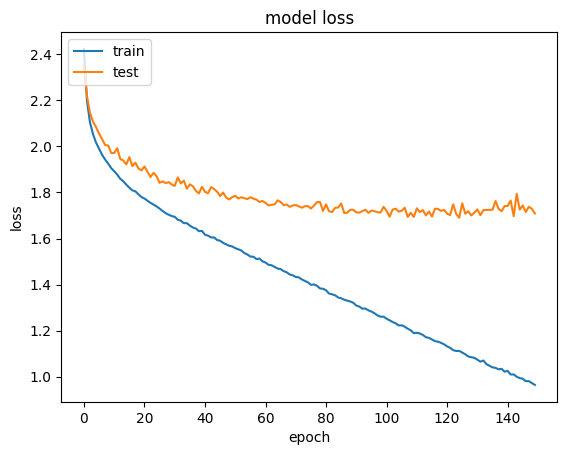

In [31]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
# Save model and weights
model_name = 'Emotion_Model_aug.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json_aug.json", "w") as json_file:
    json_file.write(model_json)

/Users/riasanjay/Desktop/Mental-Health-Application/fds/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Save model and weights at /Users/riasanjay/Desktop/Mental-Health-Application/saved_models/Emotion_Model_aug.h5 


In [34]:
from tensorflow.keras.optimizers.legacy import RMSprop

In [35]:
# loading json and model architecture 
json_file = open('model_json_aug.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model_aug.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = RMSprop(learning_rate=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 41.32%


## 2D CNN using MFCC

In [ ]:
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation, Input, Dense)

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
from tqdm import tqdm, tqdm_pandas
import scipy
from scipy.stats import skew
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import sys
import IPython.display as ipd  # To play sound in the notebook
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [37]:
def get_2d_conv_model(n):
    ''' Create a standard deep 2D convolutional neural network'''
    nclass = 14
    inp = Input(shape=(n,216,1))  #2D matrix of 30 MFCC bands by 216 audio length.
    x = Convolution2D(32, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Flatten()(x)
    x = Dense(64)(x)
    x = Dropout(rate=0.2)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(rate=0.2)(x)
    
    out = Dense(nclass, activation=softmax)(x)
    model = models.Model(inputs=inp, outputs=out)
    
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

In [38]:
import pandas as pd

# Load the dataset
data_path = "Data_path.csv"  # Replace with your actual file path
df = pd.read_csv(data_path)

# Check for basic information
print("Dataset Info:")
print(df.info())

# Check the first few rows to confirm the structure
print("\nFirst few rows of the dataset:")
print(df.head())

# Distribution of each label
print("\nLabel Distribution:")
label_distribution = df['labels'].value_counts()
print(label_distribution)

# Distribution of each source
print("\nSource Distribution:")
source_distribution = df['source'].value_counts()
print(source_distribution)

# Combine label and source distributions
print("\nLabel and Source Distribution:")
label_source_distribution = df.groupby(['labels', 'source']).size().reset_index(name='count')
print(label_source_distribution)


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10771 entries, 0 to 10770
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   labels  10771 non-null  object
 1   source  10771 non-null  object
 2   path    10771 non-null  object
dtypes: object(3)
memory usage: 252.6+ KB
None

First few rows of the dataset:
       labels source                                               path
0  male_angry  SAVEE  /Users/riasanjay/Desktop/Mental-Health-Applica...
1  male_angry  SAVEE  /Users/riasanjay/Desktop/Mental-Health-Applica...
2  male_angry  SAVEE  /Users/riasanjay/Desktop/Mental-Health-Applica...
3  male_angry  SAVEE  /Users/riasanjay/Desktop/Mental-Health-Applica...
4  male_angry  SAVEE  /Users/riasanjay/Desktop/Mental-Health-Applica...

Label Distribution:
labels
female_sad         942
female_happy       896
female_angry       896
female_fear        896
female_disgust     858
female_neutral     856
male_neutral       83

In [42]:
import pandas as pd

# Load the dataset
data_path = "data_path.csv"  # Replace with your actual CSV file path
df = pd.read_csv(data_path)

# Define the target class size
target_class_size = 500

# Balance the dataset
balanced_df = df.groupby('labels').apply(
    lambda x: x.sample(n=target_class_size, replace=(len(x) < target_class_size), random_state=42)
).reset_index(drop=True)

# Check the balanced distribution
print("Balanced dataset distribution:")
print(balanced_df['labels'].value_counts())

# Save the balanced dataset
balanced_df.to_csv("balanced_data_path.csv", index=False)
print("Balanced dataset saved to 'balanced_data_path.csv'")


Balanced dataset distribution:
labels
female_angry       500
female_disgust     500
female_fear        500
female_happy       500
female_neutral     500
female_sad         500
female_surprise    500
male_angry         500
male_disgust       500
male_fear          500
male_happy         500
male_neutral       500
male_sad           500
male_surprise      500
Name: count, dtype: int64
Balanced dataset saved to 'balanced_data_path.csv'


/var/folders/0h/k_jv3w5d10l90m2_mx1d08tw0000gn/T/ipykernel_1494/2791957890.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('labels').apply(


## Data Augmentation

In [60]:
import librosa
import numpy as np
import soundfile as sf
import os
import pandas as pd

def augment_audio(file_path, sr=16000, noise_level=0.02, stretch_rate=1.1, pitch_steps=2, shift_max=0.2):
    """
    Apply multiple augmentations to an audio file.
    """
    audio, _ = librosa.load(file_path, sr=sr)
    augmented_data = []

    # Original
    augmented_data.append(audio)

    # Add Gaussian noise
    def add_noise(audio, noise_level):
        noise = np.random.randn(len(audio))
        return np.clip(audio + noise_level * noise, -1.0, 1.0)
    augmented_data.append(add_noise(audio, noise_level))

    # Pitch shifting
    def pitch_shift(audio, sr, n_steps):
        return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)
    augmented_data.append(pitch_shift(audio, sr, pitch_steps))

    # Time shifting
    def time_shift(audio, shift_max, sr):
        shift = int(np.random.uniform(-shift_max, shift_max) * sr)
        return np.roll(audio, shift)
    augmented_data.append(time_shift(audio, shift_max, sr))

    return augmented_data


In [61]:
import pandas as pd
import soundfile as sf
import os

# Load dataset
df = pd.read_csv("/Users/riasanjay/Desktop/Mental-Health-Application/balanced_data_path.csv")  # Replace with your dataset

# Directory to save augmented files
output_dir = "augmented_dataset"
os.makedirs(output_dir, exist_ok=True)

# Process the dataset
augmented_rows = []
for idx, row in df.iterrows():
    file_path = row['path']
    label = row['labels']
    source = row['source']
    
    try:
        # Perform augmentations
        augmented_audios = augment_audio(file_path)
        
        # Save augmented audio files
        for i, audio in enumerate(augmented_audios):
            output_path = f"{output_dir}/{os.path.basename(file_path).split('.')[0]}_aug_{i}.wav"
            sf.write(output_path, audio, samplerate=16000)
            augmented_rows.append({"labels": label, "source": source, "path": output_path, "augmentation": f"aug_{i}"})
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Create a DataFrame for the augmented dataset
augmented_df = pd.DataFrame(augmented_rows)

# Save the augmented dataset to a new CSV file
augmented_df.to_csv("augmented_data_path.csv", index=False)
print("Augmented dataset saved to 'augmented_data_path.csv'")


Augmented dataset saved to 'augmented_data_path.csv'


In [59]:
file_path

'/Users/riasanjay/Desktop/Mental-Health-Application/RAVDESS/Actor_23/03-01-08-01-02-01-23.wav'

In [62]:
import librosa

def extract_mfcc(file_path, sr=16000, n_mfcc=13):
    audio, _ = librosa.load(file_path, sr=sr)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfccs.T, axis=0)  # Take the mean over time

In [65]:
# Extract features for all files in your dataset
def extract_features_for_dataset(df, sr=16000):
    features = []
    for idx, row in df.iterrows():
        file_path = row['path']
        try:
            feature_vector = extract_mfcc(file_path, sr=sr)
            features.append(feature_vector)
        except Exception as e:
            print(f"Error extracting features from {file_path}: {e}")
    return np.array(features)

# Usage
features = extract_features_for_dataset(augmented_df)


In [66]:
print(f"Features shape: {features.shape}")

Features shape: (28000, 13)


In [ ]:
features

array([[-294.69217  ,   92.98823  ,   14.527917 , ...,   -5.5558   ,
          -3.3669975,   -5.6278734],
       [-132.12895  ,   20.41351  ,    4.793359 , ...,   -2.8105938,
          -4.2121177,   -3.9276378],
       [-318.83038  ,   93.08376  ,    8.274335 , ...,   -7.1217356,
          -3.144035 ,   -6.775542 ],
       ...,
       [-151.9449   ,    7.4984965,    0.7882621, ...,   -0.6445713,
          -1.8266027,   -1.586246 ],
       [-561.7218   ,   42.274376 ,  -14.651061 , ...,  -10.161702 ,
          -3.8598993,   -8.687333 ],
       [-543.769    ,   43.508564 ,  -10.796753 , ...,   -5.900601 ,
          -2.23419  ,   -6.1218433]], dtype=float32)

In [69]:
import numpy as np

# Define time steps and coefficients
num_frames = 28  # You can adjust this based on your preference
num_coeffs = 13

# Ensure the total number of features is divisible by num_frames
if features.shape[0] % num_frames != 0:
    raise ValueError("The number of samples is not divisible by the number of frames. Adjust num_frames.")

# Reshape features
num_samples = features.shape[0] // num_frames
reshaped_features = features.reshape(num_samples, num_frames, num_coeffs, 1)
print(f"Reshaped features shape: {reshaped_features.shape}")


Reshaped features shape: (1000, 28, 13, 1)


In [75]:
import numpy as np

# Extract labels from the DataFrame
labels = augmented_df['labels'].values  # Assuming 'labels' column exists in your DataFrame
print(f"Labels shape: {labels.shape}")


Labels shape: (28000,)


In [77]:
# Assuming you have labels for each original sample
label = np.array(labels)  # Replace with your actual labels array

# Reshape labels to match the new number of samples
reshaped_labels = labels[:num_samples * num_frames].reshape(num_samples, num_frames)
reshaped_labels = reshaped_labels[:, 0]  # Take the label of the first frame for simplicity
print(f"Reshaped labels shape: {reshaped_labels.shape}")

Reshaped labels shape: (1000,)


In [78]:
# Train-test split
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Encode labels
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(reshaped_labels)
categorical_labels = to_categorical(encoded_labels)

# Split data
X_train, X_test, y_train, y_test = train_test_split(reshaped_features, categorical_labels, test_size=0.2, random_state=42)

In [83]:
# Add a spatial dimension to the features
reshaped_features = reshaped_features.reshape(reshaped_features.shape[0], 28, 13, 1)
print(f"Reshaped features shape: {reshaped_features.shape}")

Reshaped features shape: (1000, 28, 13, 1)


In [84]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, TimeDistributed, Dense, Dropout

# Define CNN-LSTM Model
model = Sequential([
    # CNN layers (for spatial feature extraction)
    TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(28, 13, 1, 1)),  # Fixed time steps
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Conv2D(64, (3, 3), activation='relu')),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Flatten()),

    # LSTM layers (for temporal feature extraction)
    LSTM(128, return_sequences=False),
    Dropout(0.5),

    # Fully connected layers
    Dense(64, activation='relu'),
    Dense(categorical_labels.shape[1], activation='softmax')  # Output layer for num_classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()



ValueError: One of the dimensions in the output is <= 0 due to downsampling in conv2d_4. Consider increasing the input size. Received input shape [None, 13, 1, 1] which would produce output shape with a zero or negative value in a dimension.

In [80]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50


ValueError: in user code:

    File "/Users/riasanjay/Desktop/Mental-Health-Application/fds/lib/python3.9/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/Users/riasanjay/Desktop/Mental-Health-Application/fds/lib/python3.9/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/riasanjay/Desktop/Mental-Health-Application/fds/lib/python3.9/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/Users/riasanjay/Desktop/Mental-Health-Application/fds/lib/python3.9/site-packages/keras/src/engine/training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "/Users/riasanjay/Desktop/Mental-Health-Application/fds/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/riasanjay/Desktop/Mental-Health-Application/fds/lib/python3.9/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_5" is incompatible with the layer: expected shape=(None, None, 28, 13, 1), found shape=(32, 28, 13, 1)


In [81]:
print(reshaped_features.shape)  # Should output (num_samples, 28, 13, 1)

(1000, 28, 13, 1)


# EMOTIONAL SPEECH RECOGNITION

## Importing the libraries

In [ ]:
import os

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import librosa 
import librosa.display

# to play the audio files
from IPython.display import Audio


In [106]:
sns.set_style("whitegrid")

## Dataset Sorting

In [ ]:
import pandas as pd

# Load the combined dataset
df = pd.read_csv("/Users/riasanjay/Desktop/Mental-Health-Application/Data_path.csv")

# label groups
male_labels = [
    "male_angry", "male_disgust", "male_fear", "male_happy",
    "male_neutral", "male_sad", "male_surprise"
]

female_labels = [
    "female_neutral", "female_sad", "female_happy", "female_angry",
    "female_surprise", "female_disgust", "female_fear"
]

#datasets
datasets = ["CREMA", "TESS", "SAVEE", "RAVDESS"]

# separate DataFrames for each dataset, grouped by gender
dataframes = {}
for dataset in datasets:
    # rows for the current dataset
    dataset_df = df[df["source"] == dataset]

    male_df = dataset_df[dataset_df["labels"].isin(male_labels)].reset_index(drop=True)
    female_df = dataset_df[dataset_df["labels"].isin(female_labels)].reset_index(drop=True)
    
    dataframes[f"{dataset}_male"] = male_df
    dataframes[f"{dataset}_female"] = female_df

for name, dataframe in dataframes.items():
    dataframe.to_csv(f"{name}.csv", index=False)
    print(f"Saved {name}.csv with {len(dataframe)} rows")


Saved CREMA_male.csv with 3930 rows
Saved CREMA_female.csv with 3512 rows
Saved TESS_male.csv with 0 rows
Saved TESS_female.csv with 1409 rows
Saved SAVEE_male.csv with 480 rows
Saved SAVEE_female.csv with 0 rows
Saved RAVDESS_male.csv with 720 rows
Saved RAVDESS_female.csv with 720 rows


In [ ]:
import pandas as pd

file_names = [
    "CREMA_male.csv", "CREMA_female.csv",
    "TESS_male.csv", "TESS_female.csv",
    "SAVEE_male.csv", "SAVEE_female.csv",
    "RAVDESS_male.csv", "RAVDESS_female.csv"
]

# Dictionary to store DataFrames
dataframes = {}

for file_name in file_names:
    dataframe_name = file_name.split(".")[0]  # Extract the name without ".csv"
    dataframes[dataframe_name] = pd.read_csv(file_name)
    print(f"Loaded {dataframe_name} with {len(dataframes[dataframe_name])} rows")

crema_male_df = dataframes["CREMA_male"]
print(crema_male_df.head())


Loaded CREMA_male with 3930 rows
Loaded CREMA_female with 3512 rows
Loaded TESS_male with 0 rows
Loaded TESS_female with 1409 rows
Loaded SAVEE_male with 480 rows
Loaded SAVEE_female with 0 rows
Loaded RAVDESS_male with 720 rows
Loaded RAVDESS_female with 720 rows
         labels source                                               path
0    male_angry  CREMA  /Users/riasanjay/Desktop/Mental-Health-Applica...
1  male_disgust  CREMA  /Users/riasanjay/Desktop/Mental-Health-Applica...
2     male_fear  CREMA  /Users/riasanjay/Desktop/Mental-Health-Applica...
3    male_happy  CREMA  /Users/riasanjay/Desktop/Mental-Health-Applica...
4  male_neutral  CREMA  /Users/riasanjay/Desktop/Mental-Health-Applica...


In [280]:
SAVEE_df = df[df["source"] == "SAVEE"]

In [281]:
TESS_df = df[df["source"] == "TESS"]

In [282]:
SAVEE_df

labels source                                               path
0       male_angry  SAVEE  /Users/riasanjay/Desktop/Mental-Health-Applica...
1       male_angry  SAVEE  /Users/riasanjay/Desktop/Mental-Health-Applica...
2       male_angry  SAVEE  /Users/riasanjay/Desktop/Mental-Health-Applica...
3       male_angry  SAVEE  /Users/riasanjay/Desktop/Mental-Health-Applica...
4       male_angry  SAVEE  /Users/riasanjay/Desktop/Mental-Health-Applica...
..             ...    ...                                                ...
475  male_surprise  SAVEE  /Users/riasanjay/Desktop/Mental-Health-Applica...
476  male_surprise  SAVEE  /Users/riasanjay/Desktop/Mental-Health-Applica...
477  male_surprise  SAVEE  /Users/riasanjay/Desktop/Mental-Health-Applica...
478  male_surprise  SAVEE  /Users/riasanjay/Desktop/Mental-Health-Applica...
479  male_surprise  SAVEE  /Users/riasanjay/Desktop/Mental-Health-Applica...

[480 rows x 3 columns]

In [ ]:
ravdess_male_df = dataframes["RAVDESS_male"]
print(ravdess_male_df.head())  

       labels   source                                               path
0   male_fear  RAVDESS  /Users/riasanjay/Desktop/Mental-Health-Applica...
1  male_angry  RAVDESS  /Users/riasanjay/Desktop/Mental-Health-Applica...
2  male_happy  RAVDESS  /Users/riasanjay/Desktop/Mental-Health-Applica...
3   male_fear  RAVDESS  /Users/riasanjay/Desktop/Mental-Health-Applica...
4  male_happy  RAVDESS  /Users/riasanjay/Desktop/Mental-Health-Applica...


In [ ]:
crema_female_df = dataframes["CREMA_female"]
print(crema_female_df.head()) 

           labels source                                               path
0    female_angry  CREMA  /Users/riasanjay/Desktop/Mental-Health-Applica...
1  female_disgust  CREMA  /Users/riasanjay/Desktop/Mental-Health-Applica...
2     female_fear  CREMA  /Users/riasanjay/Desktop/Mental-Health-Applica...
3    female_happy  CREMA  /Users/riasanjay/Desktop/Mental-Health-Applica...
4  female_neutral  CREMA  /Users/riasanjay/Desktop/Mental-Health-Applica...


In [ ]:
ravdess_female_df = dataframes["RAVDESS_female"]
print(ravdess_female_df.head()) 

           labels   source                                               path
0  female_neutral  RAVDESS  /Users/riasanjay/Desktop/Mental-Health-Applica...
1  female_neutral  RAVDESS  /Users/riasanjay/Desktop/Mental-Health-Applica...
2      female_sad  RAVDESS  /Users/riasanjay/Desktop/Mental-Health-Applica...
3    female_happy  RAVDESS  /Users/riasanjay/Desktop/Mental-Health-Applica...
4    female_angry  RAVDESS  /Users/riasanjay/Desktop/Mental-Health-Applica...


In [286]:
male_df

labels   source                                               path
0        male_fear  RAVDESS  /Users/riasanjay/Desktop/Mental-Health-Applica...
1       male_angry  RAVDESS  /Users/riasanjay/Desktop/Mental-Health-Applica...
2       male_happy  RAVDESS  /Users/riasanjay/Desktop/Mental-Health-Applica...
3        male_fear  RAVDESS  /Users/riasanjay/Desktop/Mental-Health-Applica...
4       male_happy  RAVDESS  /Users/riasanjay/Desktop/Mental-Health-Applica...
..             ...      ...                                                ...
715  male_surprise  RAVDESS  /Users/riasanjay/Desktop/Mental-Health-Applica...
716  male_surprise  RAVDESS  /Users/riasanjay/Desktop/Mental-Health-Applica...
717  male_surprise  RAVDESS  /Users/riasanjay/Desktop/Mental-Health-Applica...
718  male_surprise  RAVDESS  /Users/riasanjay/Desktop/Mental-Health-Applica...
719  male_surprise  RAVDESS  /Users/riasanjay/Desktop/Mental-Health-Applica...

[720 rows x 3 columns]

In [287]:
female_df

labels   source  \
0     female_neutral  RAVDESS   
1     female_neutral  RAVDESS   
2         female_sad  RAVDESS   
3       female_happy  RAVDESS   
4       female_angry  RAVDESS   
..               ...      ...   
715  female_surprise  RAVDESS   
716  female_surprise  RAVDESS   
717   female_disgust  RAVDESS   
718   female_disgust  RAVDESS   
719  female_surprise  RAVDESS   

                                                  path  
0    /Users/riasanjay/Desktop/Mental-Health-Applica...  
1    /Users/riasanjay/Desktop/Mental-Health-Applica...  
2    /Users/riasanjay/Desktop/Mental-Health-Applica...  
3    /Users/riasanjay/Desktop/Mental-Health-Applica...  
4    /Users/riasanjay/Desktop/Mental-Health-Applica...  
..                                                 ...  
715  /Users/riasanjay/Desktop/Mental-Health-Applica...  
716  /Users/riasanjay/Desktop/Mental-Health-Applica...  
717  /Users/riasanjay/Desktop/Mental-Health-Applica...  
718  /Users/riasanjay/Desktop/Mental-Health-Applica...  
719  /Users/riasanjay/Desktop/Mental-Health-Applica...  

[720 rows x 3 columns]

In [ ]:
Males = pd.concat([SAVEE_df, ravdess_male_df, crema_male_df], axis = 0)
Males.to_csv("males_emotions_df.csv", index = False)

Females = pd.concat([TESS_df, ravdess_female_df, crema_female_df], axis = 0)
Females.to_csv("females_emotions_df.csv", index = False)

In [289]:
Males

labels source                                               path
0       male_angry  SAVEE  /Users/riasanjay/Desktop/Mental-Health-Applica...
1       male_angry  SAVEE  /Users/riasanjay/Desktop/Mental-Health-Applica...
2       male_angry  SAVEE  /Users/riasanjay/Desktop/Mental-Health-Applica...
3       male_angry  SAVEE  /Users/riasanjay/Desktop/Mental-Health-Applica...
4       male_angry  SAVEE  /Users/riasanjay/Desktop/Mental-Health-Applica...
...            ...    ...                                                ...
3925  male_disgust  CREMA  /Users/riasanjay/Desktop/Mental-Health-Applica...
3926     male_fear  CREMA  /Users/riasanjay/Desktop/Mental-Health-Applica...
3927    male_happy  CREMA  /Users/riasanjay/Desktop/Mental-Health-Applica...
3928  male_neutral  CREMA  /Users/riasanjay/Desktop/Mental-Health-Applica...
3929      male_sad  CREMA  /Users/riasanjay/Desktop/Mental-Health-Applica...

[5130 rows x 3 columns]

In [290]:
Females

labels source                                               path
1920     female_fear   TESS  /Users/riasanjay/Desktop/Mental-Health-Applica...
1921     female_fear   TESS  /Users/riasanjay/Desktop/Mental-Health-Applica...
1922     female_fear   TESS  /Users/riasanjay/Desktop/Mental-Health-Applica...
1923     female_fear   TESS  /Users/riasanjay/Desktop/Mental-Health-Applica...
1924     female_fear   TESS  /Users/riasanjay/Desktop/Mental-Health-Applica...
...              ...    ...                                                ...
3507  female_disgust  CREMA  /Users/riasanjay/Desktop/Mental-Health-Applica...
3508     female_fear  CREMA  /Users/riasanjay/Desktop/Mental-Health-Applica...
3509    female_happy  CREMA  /Users/riasanjay/Desktop/Mental-Health-Applica...
3510  female_neutral  CREMA  /Users/riasanjay/Desktop/Mental-Health-Applica...
3511      female_sad  CREMA  /Users/riasanjay/Desktop/Mental-Health-Applica...

[5641 rows x 3 columns]

## Augmentation

In [ ]:
def noise(data):
    noise_amp = 0.04*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data
def stretch(data, rate=0.70):
    return librosa.effects.time_stretch(data, rate=0.7)
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data.astype(np.float32), shift_range)

def pitch(data, sampling_rate, pitch_factor=0.8):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=0.8)

def higher_speed(data, speed_factor = 1.25):
    return librosa.effects.time_stretch(data, rate = 1.25)
def lower_speed(data, speed_factor = 0.75):
    return librosa.effects.time_stretch(data, rate= 0.75)

## Extracting MFCC features

In [ ]:
def extract_features(data):
    
    result = np.array([])
    
    mfccs = librosa.feature.mfcc(y=data, sr=22050, n_mfcc=58)
    mfccs_processed = np.mean(mfccs.T,axis=0)
    result = np.array(mfccs_processed)
     
    return result

def get_features(path):
  
    data, sample_rate = librosa.load(path, duration=3, offset=0.5, res_type='scipy')
    print(f"Loaded data shape: {data.shape}, Sample rate: {sample_rate}")
    
    res1 = extract_features(data)
    result = np.array(res1)
    
    augmentations = {
        "noised": noise(data),
        "stretched": stretch(data,rate=0.7),
        "shifted": shift(data),
        "pitched": pitch(data, sample_rate),
        "higher_speed": higher_speed(data, speed_factor=1.25),
        "lower_speed": lower_speed(data, speed_factor=0.75),
    }

    for aug_name, aug_data in augmentations.items():
        print(f"Applying augmentation: {aug_name}, Data shape: {aug_data.shape}")
        res_aug = extract_features(aug_data)
        result = np.vstack((result, res_aug)) 

    return result


In [160]:
female_X, female_Y = [], []
for path, emotion in zip(Females.path, Females.labels):
        features = get_features(path)
        #adding augmentation, get_features return a multi dimensional array (for each augmentation), so we have to use a loop to fill the df
        for elem in features: 
            female_X.append(elem)        
            female_Y.append(emotion)
    

male_X, male_Y = [], []
for path, emotion in zip(Males.path, Males.labels):
        features = get_features(path)
        for elem in features:
            male_X.append(elem)
            male_Y.append(emotion)
            
print(f'Check shapes:\nFemale features: {len(female_X)}, labels: {len(female_Y)}\nMale features:   {len(male_X)}, labels: {len(male_Y)}')

Loaded data shape: (27059,), Sample rate: 22050
Applying augmentation: noised, Data shape: (27059,)
Applying augmentation: stretched, Data shape: (38656,)
Applying augmentation: shifted, Data shape: (27059,)
Applying augmentation: pitched, Data shape: (27059,)
Applying augmentation: higher_speed, Data shape: (21647,)
Applying augmentation: lower_speed, Data shape: (36079,)
Loaded data shape: (17824,), Sample rate: 22050
Applying augmentation: noised, Data shape: (17824,)
Applying augmentation: stretched, Data shape: (25463,)
Applying augmentation: shifted, Data shape: (17824,)
Applying augmentation: pitched, Data shape: (17824,)
Applying augmentation: higher_speed, Data shape: (14259,)
Applying augmentation: lower_speed, Data shape: (23765,)
Loaded data shape: (30190,), Sample rate: 22050
Applying augmentation: noised, Data shape: (30190,)
Applying augmentation: stretched, Data shape: (43129,)
Applying augmentation: shifted, Data shape: (30190,)
Applying augmentation: pitched, Data sha

In [326]:
print(f'Check shapes:\nFemale features: {len(female_X)}, labels: {len(female_Y)}\nMale features:   {len(male_X)}, labels: {len(male_Y)}')

Check shapes:
Female features: 39487, labels: 39487
Male features:   35910, labels: 35910


In [291]:
def setup_dataframe(gender, features, labels):
    df = pd.DataFrame(features)
    df['labels'] = labels
    df.to_csv(f'{gender}_features.csv', index=False)
    
    print(f'{gender} dataframe')
    df.sample(frac=1).head()
    
    return df

In [329]:
Females_Features = setup_dataframe('Female', female_X, female_Y)

Female dataframe


In [330]:
Males_Features = setup_dataframe('Male', male_X, male_Y)

Male dataframe


In [333]:
Females_Features

0           1          2          3          4          5  \
0     -444.406738   89.938805   0.729242 -18.629259   4.526076   2.561800   
1     -244.092491   27.053273   0.927256  -8.498582  -3.454638  -0.312219   
2     -465.724365   90.311813  -2.261394 -22.772165   2.471380   2.351565   
3     -439.910187   90.430481   1.247040 -17.941818   4.171274   2.345693   
4     -461.158722   92.007545  -8.398488 -24.348936   3.960326   1.749310   
...           ...         ...        ...        ...        ...        ...   
39482 -484.374817  119.176094  16.781576  49.574665 -10.468652  39.293591   
39483 -447.092407  124.261528  14.347409  51.071148 -13.178314  41.200401   
39484 -477.450623  117.932121  20.564600  45.570477  -7.055764  37.725220   
39485 -480.929108  122.486275  12.938518  50.825016 -15.810259  41.111526   
39486 -483.091125  120.673851  15.802386  50.316044 -11.433032  41.511784   

               6          7          8          9  ...        49        50  \
0     -11.547450  -1.341434  -9.212708   0.598168  ...  4.135319  1.025927   
1      -2.029054  -2.406527  -3.170201  -1.789698  ...  3.368249  2.234312   
2     -12.022738  -1.593081 -10.317836  -0.597055  ...  4.146862  0.616500   
3     -10.797819  -1.715647 -10.051782   0.095465  ...  4.173862  1.264275   
4     -12.990678  -1.096370 -10.317229   0.908417  ...  2.268151  2.319406   
...          ...        ...        ...        ...  ...       ...       ...   
39482 -17.770967  16.153549 -12.421471  17.774162  ...  0.729680 -4.078815   
39483 -19.033985  17.885641 -12.687422  17.434788  ...  0.869401 -3.973233   
39484 -18.393961  18.462795 -13.066144  21.360201  ... -6.277013  0.083764   
39485 -20.646200  16.669289 -15.004034  17.780508  ...  1.407203 -3.485868   
39486 -17.812170  16.718426 -12.746357  17.344191  ...  1.011881 -3.569280   

             51        52        53        54        55        56        57  \
0      2.174302  4.661101  0.967485  2.325735  3.420523  0.512227 -0.378900   
1      1.722711  1.006681  0.522793 -0.075840  0.421843  0.198929  0.357001   
2      2.058735  4.522505  0.916637  2.000479  3.173384  0.751070  0.127624   
3      2.205888  4.439594  0.839258  2.245604  3.255363  0.282425 -0.327986   
4      6.424875  0.294833  2.801231  2.441294  0.896216 -1.081020  2.320302   
...         ...       ...       ...       ...       ...       ...       ...   
39482 -2.133258 -6.146412  3.989180 -1.913702  1.702216 -5.644912 -1.017456   
39483 -1.359483 -6.334773  3.072671 -2.127006  1.644800 -5.753110 -1.442635   
39484 -4.094638  2.596976 -4.315040 -0.889818 -3.595064  0.389039  1.397850   
39485 -0.836780 -5.510989  4.156980 -1.164254  1.045425 -5.682179 -1.247862   
39486 -0.994698 -6.010795  3.219408 -2.287697  1.364455 -5.792187 -1.481576   

            labels  
0      female_fear  
1      female_fear  
2      female_fear  
3      female_fear  
4      female_fear  
...            ...  
39482   female_sad  
39483   female_sad  
39484   female_sad  
39485   female_sad  
39486   female_sad  

[39487 rows x 59 columns]

## Data Preparation

In [164]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [401]:
female_X = Females_Features.iloc[: ,:-1].values
female_Y_raw = Females_Features['labels'].values

male_X = Males_Features.iloc[: ,:-1].values
male_Y_raw = Males_Features['labels'].values

In [ ]:
encoderM = OneHotEncoder()
encoderF = OneHotEncoder()

female_Y = encoderF.fit_transform(np.array(female_Y_raw).reshape(-1,1)).toarray()
male_Y = encoderM.fit_transform(np.array(male_Y_raw).reshape(-1,1)).toarray()

In [411]:
nogender_X = np.concatenate((female_X, male_X))
nogender_Y = np.concatenate((female_Y, male_Y))

x_train, x_test, y_train, y_test = train_test_split(nogender_X, nogender_Y, random_state=0, test_size=0.20, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60317, 58), (60317, 7), (15080, 58), (15080, 7))

In [412]:
# Save the encoder
with open('female_encoder.pkl', 'wb') as file:
    pickle.dump(encoderF, file)

print("Encoder saved as 'female_encoder.pkl'")

Encoder saved as 'female_encoder.pkl'


In [413]:
# Save the encoder
with open('male_encoder.pkl', 'wb') as file:
    pickle.dump(encoderF, file)

print("Encoder saved as 'male_encoder.pkl'")

Encoder saved as 'male_encoder.pkl'


In [416]:
x_trainF, x_testF, y_trainF, y_testF = train_test_split(female_X, female_Y, random_state=0, test_size=0.20, shuffle=True)
x_trainF.shape, y_trainF.shape, x_testF.shape, y_testF.shape

((31589, 58), (31589, 7), (7898, 58), (7898, 7))

In [417]:
x_trainM, x_testM, y_trainM, y_testM = train_test_split(male_X, male_Y, random_state=0, test_size=0.20, shuffle=True)
x_trainM.shape, y_trainM.shape, x_testM.shape, y_testM.shape

((28728, 58), (28728, 7), (7182, 58), (7182, 7))

In [374]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape , x_test.shape , y_test.shape

((60317, 58, 1), (60317, 7), (15080, 58, 1), (15080, 7))

In [375]:
x_trainF = np.expand_dims(x_trainF, axis=2)
x_testF = np.expand_dims(x_testF, axis=2)
x_trainF.shape, y_trainF.shape, x_testF.shape, y_testF.shape

((31589, 58, 1), (31589, 7), (7898, 58, 1), (7898, 7))

In [376]:
x_trainM = np.expand_dims(x_trainM, axis=2)
x_testM = np.expand_dims(x_testM, axis=2)
x_trainM.shape, y_trainM.shape, x_testM.shape, y_testM.shape

((28728, 58, 1), (28728, 7), (7182, 58, 1), (7182, 7))

## Data Modeling

In [175]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, AveragePooling1D
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

In [ ]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Number of devices: 1


In [183]:
with strategy.scope():
    
    def build_model(in_shape):
        
        model=Sequential()
        model.add(Conv1D(256, kernel_size=6, strides=1, padding='same', activation='relu', input_shape=(in_shape, 1)))
        model.add(AveragePooling1D(pool_size=4, strides = 2, padding = 'same'))

        model.add(Conv1D(128, kernel_size=6, strides=1, padding='same', activation='relu'))
        model.add(AveragePooling1D(pool_size=4, strides = 2, padding = 'same'))

        model.add(Conv1D(128, kernel_size=6, strides=1, padding='same', activation='relu'))
        model.add(AveragePooling1D(pool_size=4, strides = 2, padding = 'same'))
        model.add(Dropout(0.2))

        model.add(Conv1D(64, kernel_size=6, strides=1, padding='same', activation='relu'))
        model.add(MaxPooling1D(pool_size=4, strides = 2, padding = 'same'))
        
        model.add(Flatten())
        model.add(Dense(units=32, activation='relu'))
        model.add(Dropout(0.3))

        model.add(Dense(units=7, activation='softmax'))
        model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
          
        
        return model

In [184]:
def model_build_summary(mod_dim, tr_features, val_features, val_labels):
    model = build_model(mod_dim)
    model.summary()
    
    score = model.evaluate(val_features, val_labels, verbose = 1)
    accuracy = 100*score[1]
    
    return model

In [185]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=4, min_lr=0.000001)

batch_size = 32
n_epochs = 75

In [186]:
def show_graphs(history):
    epochs = [i for i in range(n_epochs)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    test_acc = history.history['val_accuracy']
    test_loss = history.history['val_loss']

    fig.set_size_inches(30,12)
    ax[0].plot(epochs , train_loss , label = 'Training Loss')
    ax[0].plot(epochs , test_loss , label = 'Testing Loss')
    ax[0].set_title('Training & Testing Loss')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")

    ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
    ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
    ax[1].set_title('Training & Testing Accuracy')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    plt.show()

In [187]:
total_model = model_build_summary(x_train.shape[1], x_train, x_test, y_test)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_28 (Conv1D)          (None, 58, 256)           1792      
                                                                 
 average_pooling1d_3 (Avera  (None, 29, 256)           0         
 gePooling1D)                                                    
                                                                 
 conv1d_29 (Conv1D)          (None, 29, 128)           196736    
                                                                 
 average_pooling1d_4 (Avera  (None, 15, 128)           0         
 gePooling1D)                                                    
                                                                 
 conv1d_30 (Conv1D)          (None, 15, 128)           98432     
                                                                 
 average_pooling1d_5 (Avera  (None, 8, 128)           

In [188]:
female_model = model_build_summary(x_trainF.shape[1], x_trainF, x_testF, y_testF)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_32 (Conv1D)          (None, 58, 256)           1792      
                                                                 
 average_pooling1d_6 (Avera  (None, 29, 256)           0         
 gePooling1D)                                                    
                                                                 
 conv1d_33 (Conv1D)          (None, 29, 128)           196736    
                                                                 
 average_pooling1d_7 (Avera  (None, 15, 128)           0         
 gePooling1D)                                                    
                                                                 
 conv1d_34 (Conv1D)          (None, 15, 128)           98432     
                                                                 
 average_pooling1d_8 (Avera  (None, 8, 128)          

In [189]:
male_model = model_build_summary(x_trainM.shape[1], x_trainM, x_testM, y_testM)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_36 (Conv1D)          (None, 58, 256)           1792      
                                                                 
 average_pooling1d_9 (Avera  (None, 29, 256)           0         
 gePooling1D)                                                    
                                                                 
 conv1d_37 (Conv1D)          (None, 29, 128)           196736    
                                                                 
 average_pooling1d_10 (Aver  (None, 15, 128)           0         
 agePooling1D)                                                   
                                                                 
 conv1d_38 (Conv1D)          (None, 15, 128)           98432     
                                                                 
 average_pooling1d_11 (Aver  (None, 8, 128)          

In [190]:
history = total_model.fit(x_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/75
1885/1885 [==============================] - 19s 10ms/step - loss: 1.4603 - accuracy: 0.4022 - val_loss: 1.2664 - val_accuracy: 0.4905 - lr: 0.0010
Epoch 2/75
1885/1885 [==============================] - 18s 9ms/step - loss: 1.2726 - accuracy: 0.4911 - val_loss: 1.1757 - val_accuracy: 0.5210 - lr: 0.0010
Epoch 3/75
1885/1885 [==============================] - 18s 10ms/step - loss: 1.1935 - accuracy: 0.5276 - val_loss: 1.1084 - val_accuracy: 0.5600 - lr: 0.0010
Epoch 4/75
1885/1885 [==============================] - 18s 10ms/step - loss: 1.1350 - accuracy: 0.5529 - val_loss: 1.0666 - val_accuracy: 0.5773 - lr: 0.0010
Epoch 5/75
1885/1885 [==============================] - 18s 9ms/step - loss: 1.0831 - accuracy: 0.5768 - val_loss: 1.0176 - val_accuracy: 0.5933 - lr: 0.0010
Epoch 6/75
1885/1885 [==============================] - 18s 9ms/step - loss: 1.0363 - accuracy: 0.5962 - val_loss: 0.9960 - val_accuracy: 0.6046 - lr: 0.0010
Epoch 7/75
1885/1885 [===========================

In [191]:
female_history = female_model.fit(x_trainF, y_trainF, batch_size=batch_size, epochs=n_epochs, validation_data=(x_testF, y_testF), callbacks=[rlrp])

Epoch 1/75
988/988 [==============================] - 14s 13ms/step - loss: 1.3772 - accuracy: 0.4395 - val_loss: 1.0760 - val_accuracy: 0.5576 - lr: 0.0010
Epoch 2/75
988/988 [==============================] - 11s 11ms/step - loss: 1.1011 - accuracy: 0.5566 - val_loss: 0.9637 - val_accuracy: 0.6037 - lr: 0.0010
Epoch 3/75
988/988 [==============================] - 10s 10ms/step - loss: 1.0171 - accuracy: 0.5902 - val_loss: 0.9031 - val_accuracy: 0.6274 - lr: 0.0010
Epoch 4/75
988/988 [==============================] - 11s 11ms/step - loss: 0.9593 - accuracy: 0.6154 - val_loss: 0.9264 - val_accuracy: 0.6222 - lr: 0.0010
Epoch 5/75
988/988 [==============================] - 10s 11ms/step - loss: 0.9099 - accuracy: 0.6386 - val_loss: 0.8841 - val_accuracy: 0.6443 - lr: 0.0010
Epoch 6/75
988/988 [==============================] - 10s 10ms/step - loss: 0.8624 - accuracy: 0.6543 - val_loss: 0.7875 - val_accuracy: 0.6818 - lr: 0.0010
Epoch 7/75
988/988 [==============================] - 10s 

In [192]:
male_history = male_model.fit(x_trainM, y_trainM, batch_size=batch_size, epochs=n_epochs, validation_data=(x_testM, y_testM), callbacks=[rlrp])

Epoch 1/75
898/898 [==============================] - 11s 11ms/step - loss: 1.6485 - accuracy: 0.3261 - val_loss: 1.4724 - val_accuracy: 0.4027 - lr: 0.0010
Epoch 2/75
898/898 [==============================] - 10s 11ms/step - loss: 1.4928 - accuracy: 0.4000 - val_loss: 1.4134 - val_accuracy: 0.4442 - lr: 0.0010
Epoch 3/75
898/898 [==============================] - 10s 11ms/step - loss: 1.4220 - accuracy: 0.4343 - val_loss: 1.3381 - val_accuracy: 0.4784 - lr: 0.0010
Epoch 4/75
898/898 [==============================] - 10s 11ms/step - loss: 1.3505 - accuracy: 0.4659 - val_loss: 1.2637 - val_accuracy: 0.4996 - lr: 0.0010
Epoch 5/75
898/898 [==============================] - 10s 11ms/step - loss: 1.2960 - accuracy: 0.4841 - val_loss: 1.2427 - val_accuracy: 0.5109 - lr: 0.0010
Epoch 6/75
898/898 [==============================] - 10s 11ms/step - loss: 1.2343 - accuracy: 0.5108 - val_loss: 1.1135 - val_accuracy: 0.5685 - lr: 0.0010
Epoch 7/75
898/898 [==============================] - 10s 

In [ ]:
male_model.save('my_male_model.h5')
print("Model saved successfully.")

Model saved successfully.


/Users/riasanjay/Desktop/Mental-Health-Application/fds/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
female_model.save('my_female_model.h5')
print("Model saved successfully.")

Model saved successfully.


In [ ]:
total_model.save('my_total_model.h5')
print("Model saved successfully.")

Model saved successfully.


In [488]:
score = total_model.evaluate(x_train,y_train, verbose = 0)
print("Mixed-gender emotions training Accuracy: {0:.2%}".format(score[1]))

score = total_model.evaluate(x_test, y_test, verbose=0)
print("Mixed-gender emotions testing Accuracy: {0:.2%}".format(score[1]))

Mixed-gender emotions training Accuracy: 96.33%
Mixed-gender emotions testing Accuracy: 85.28%


In [489]:
score = female_model.evaluate(x_trainF,y_trainF, verbose = 0)
print("Female emotions training Accuracy: {0:.2%}".format(score[1]))

score = female_model.evaluate(x_testF, y_testF, verbose=0)
print("Female emotions testing Accuracy: {0:.2%}".format(score[1]))

Female emotions training Accuracy: 99.86%
Female emotions testing Accuracy: 92.01%


In [490]:
score = male_model.evaluate(x_trainM,y_trainM, verbose = 0)
print("Male emotions training Accuracy: {0:.2%}".format(score[1]))

score = male_model.evaluate(x_testM, y_testM, verbose=0)
print("Male emotions testing Accuracy: {0:.2%}".format(score[1]))

Male emotions training Accuracy: 98.59%
Male emotions testing Accuracy: 86.23%


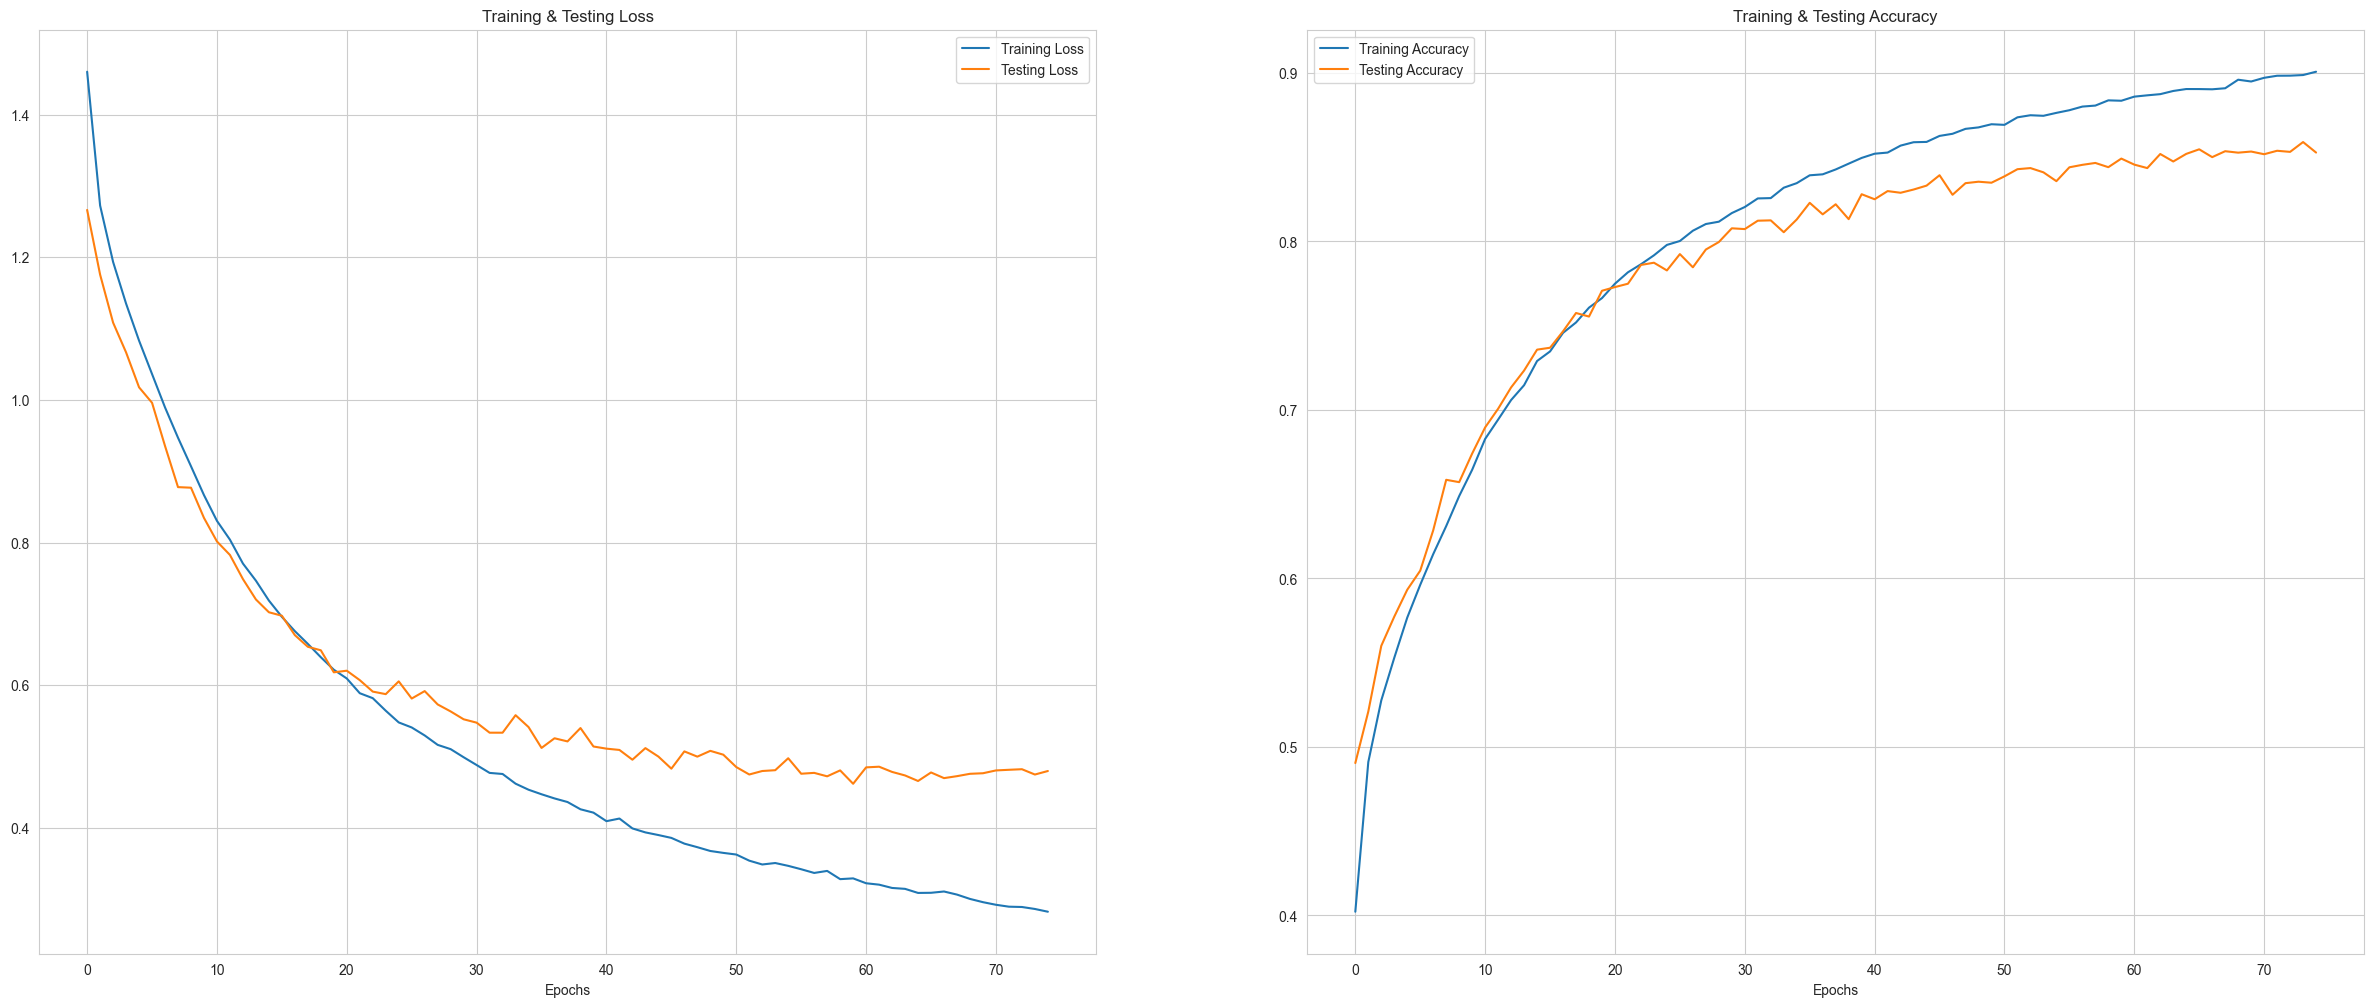

In [196]:
show_graphs(history)

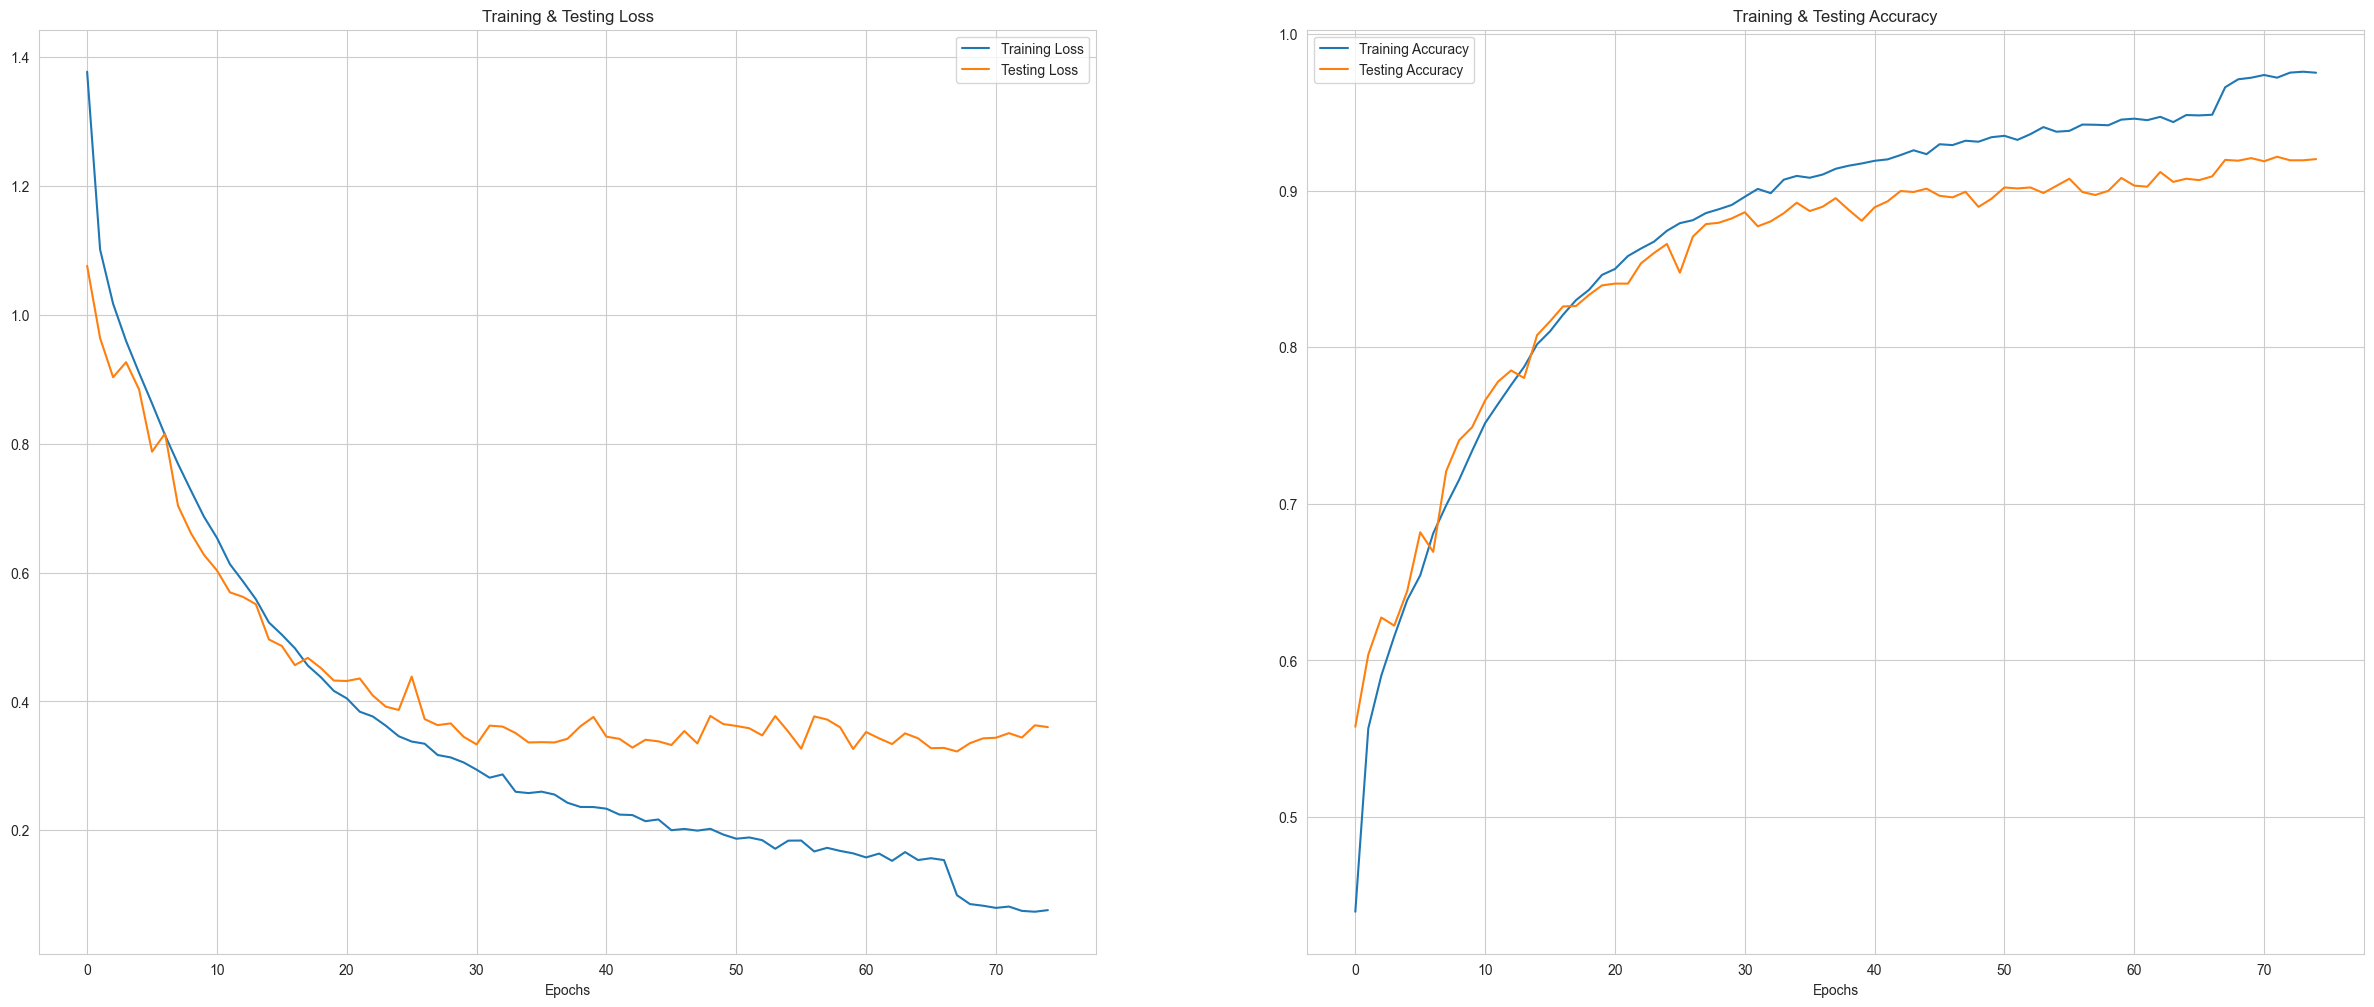

In [501]:
show_graphs(female_history)

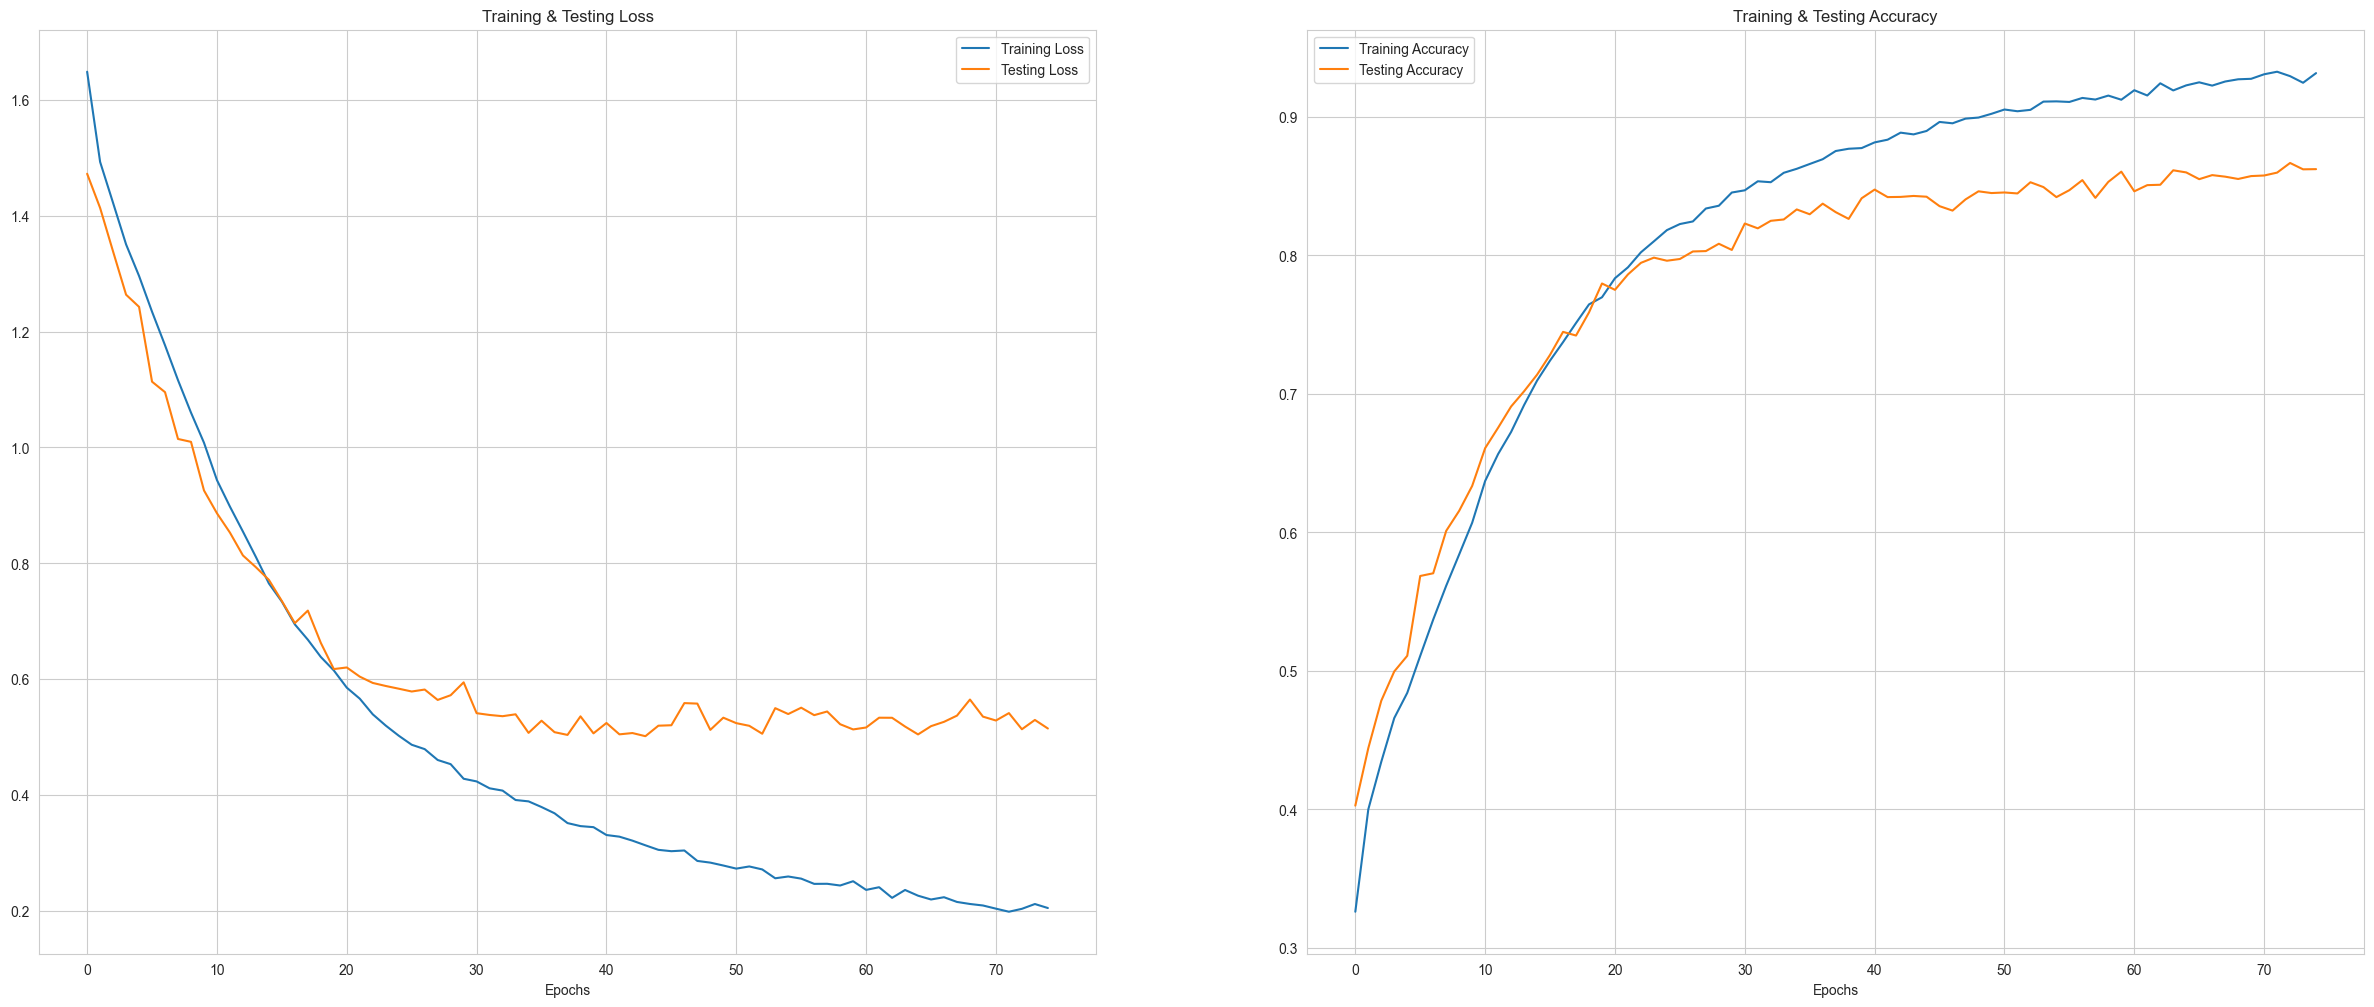

In [502]:
show_graphs(male_history)

In [ ]:
from tensorflow.keras.models import load_model
total_model = load_model('my_total_model.h5')
print("Model loaded successfully.")

female_model = load_model('my_female_model.h5')
print("Model loaded successfully.")

male_model = load_model('my_male_model.h5')
print("Model loaded successfully.")

Model loaded successfully.
Model loaded successfully.
Model loaded successfully.


In [390]:
# predicting on test data.
pred_test = female_model.predict(x_testF)
y_pred = encoderF.inverse_transform(pred_test)
y_test_ = encoderF.inverse_transform(y_testF)

247/247 [==============================] - 1s 4ms/step


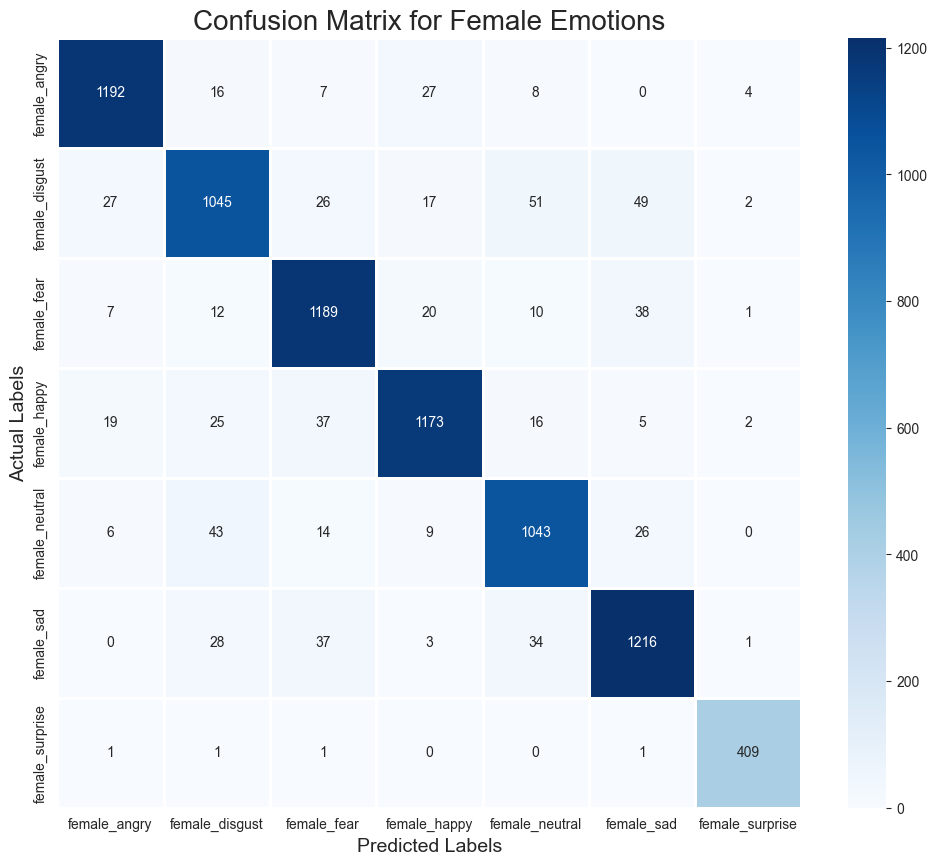

In [393]:
cm = confusion_matrix(y_test_, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoderF.categories_] , columns = [i for i in encoderF.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix for Female Emotions', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [491]:
# predicting on test data.
pred_test = male_model.predict(x_testM)
y_pred = encoderM.inverse_transform(pred_test)
y_test_ = encoderM.inverse_transform(y_testM)

225/225 [==============================] - 1s 3ms/step


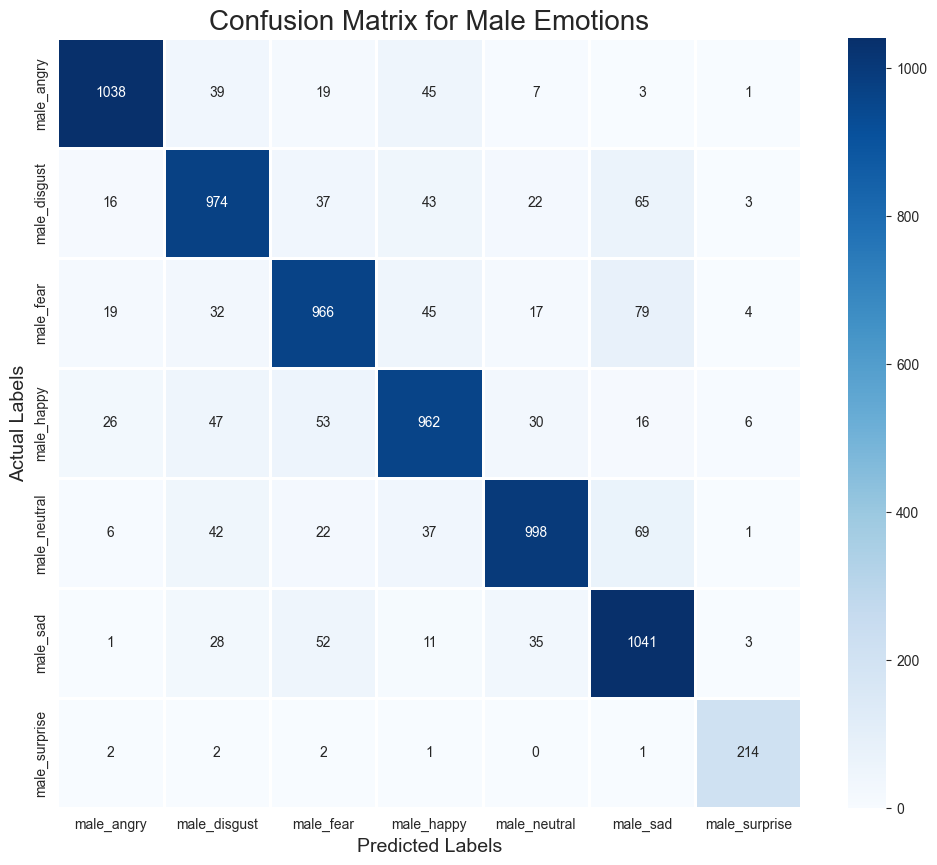

In [492]:
cm = confusion_matrix(y_test_, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoderM.categories_] , columns = [i for i in encoderM.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix for Male Emotions', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

## Real Time Testing for Male

In [ ]:
import numpy as np
import librosa
from tensorflow.keras.models import load_model
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pickle


model = load_model('my_male_model.h5')
print("Model loaded successfully.")


with open('/Users/riasanjay/Desktop/Mental-Health-Application/male_encoder.pkl', 'rb') as file:
    encoder = pickle.load(file)
print("Label encoder loaded successfully.")


Model loaded successfully.
Label encoder loaded successfully.
Scaler loaded successfully.


In [ ]:
def extract_features(data):
    mfccs = librosa.feature.mfcc(y=data, sr=22050, n_mfcc=58)
    mfccs_processed = np.mean(mfccs.T, axis=0)
    return mfccs_processed

def preprocess_audio(file_path,scaler):
    features = get_features(file_path)
    
    # Flatten features if augmentations are stacked
    if len(features.shape) > 1:
        features = features[0]  
    
    # Scale features
    scaled_features = scaler.transform([features])
    return scaled_features


In [ ]:
def predict_emotion(file_path):
    
    features = preprocess_audio(file_path, scaler)

    features = features[..., np.newaxis] 
    print("Features shape before prediction:", features.shape) 
    predictions = model.predict(features)
    predicted_label = encoderM.inverse_transform(predictions)[0][0]
    
    print(f"Predicted Emotion: {predicted_label}")
    return predicted_label


In [484]:
test_audio_path = '/Users/riasanjay/Desktop/Mental-Health-Application/TESS/TESS Toronto emotional speech set data/OAF_disgust/OAF_beg_disgust.wav'  # Replace with your test audio file path
predicted_emotion = predict_emotion(test_audio_path)

Loaded data shape: (41674,), Sample rate: 22050
Applying augmentation: noised, Data shape: (41674,)
Applying augmentation: stretched, Data shape: (59534,)
Applying augmentation: shifted, Data shape: (41674,)
Applying augmentation: pitched, Data shape: (41674,)
Applying augmentation: higher_speed, Data shape: (33339,)
Applying augmentation: lower_speed, Data shape: (55565,)
Features shape before prediction: (1, 58, 1)
1/1 [==============================] - 0s 49ms/step
Predicted Emotion: male_sad


In [447]:
print("Classes in encoder:", encoderM.categories_[0])


Classes in encoder: ['male_angry' 'male_disgust' 'male_fear' 'male_happy' 'male_neutral'
 'male_sad' 'male_surprise']


## Real time testing for Female

In [ ]:
import numpy as np
import librosa
from tensorflow.keras.models import load_model
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pickle

model = load_model('my_female_model.h5')
print("Model loaded successfully.")

with open('/Users/riasanjay/Desktop/Mental-Health-Application/female_encoder.pkl', 'rb') as file:
    encoder = pickle.load(file)
print("Label encoder loaded successfully.")

Model loaded successfully.
Label encoder loaded successfully.
Scaler loaded successfully.


In [ ]:
def extract_features(data):
    mfccs = librosa.feature.mfcc(y=data, sr=22050, n_mfcc=58)
    mfccs_processed = np.mean(mfccs.T, axis=0)
    return mfccs_processed

def preprocess_audio(file_path,scaler):
 
    features = get_features(file_path)
    
    # Flatten features if augmentations are stacked
    if len(features.shape) > 1:
        features = features[0]
    scaled_features = scaler.transform([features])
    return scaled_features


In [ ]:
def predict_emotion(file_path):
    features = preprocess_audio(file_path, scaler)

    features = features[..., np.newaxis] 
    print("Features shape before prediction:", features.shape) 
    predictions = model.predict(features)
    predicted_label = encoderF.inverse_transform(predictions)[0][0]
    
    print(f"Predicted Emotion: {predicted_label}")
    return predicted_label

In [ ]:
test_audio_path = '/Users/riasanjay/Desktop/Mental-Health-Application/15 Street 8.wav' 
predicted_emotion = predict_emotion(test_audio_path)

Loaded data shape: (66150,), Sample rate: 22050
Applying augmentation: noised, Data shape: (66150,)
Applying augmentation: stretched, Data shape: (94500,)
Applying augmentation: shifted, Data shape: (66150,)
Applying augmentation: pitched, Data shape: (66150,)
Applying augmentation: higher_speed, Data shape: (52920,)
Applying augmentation: lower_speed, Data shape: (88200,)
Features shape before prediction: (1, 58, 1)
1/1 [==============================] - 0s 101ms/step
Predicted Emotion: female_sad
